In [1]:
import sys
sys.path.append("../../src/")
import IEA_model
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import utility

from importlib import reload 

from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 

In [2]:
    data_train = utility.image_gene_dataset(train = True, cv = None)
    data_test = utility.image_gene_dataset(train = False, cv = None)

    train_loader = DataLoader(data_train)
    test_loader = DataLoader(data_test)


    sid_train, features_train, genes_train = data_train[:]
    sid_test, features_test, genes_test = data_test[:]

    sid_P1, features_P1 = utility.load_SSL_features_P1()
    features_P1 = torch.tensor(features_P1)

/ocean/projects/asc170022p/juc91/anaconda/envs/IEA/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
def get_aligned_axes(thold):

    beta = .1
    gamma = 1.0
    L = 2
    
    df = pd.read_csv("../../gene_list/THOLD_{}.txt".format(thold))
    idx_gene = df["index"].to_numpy()


    
    
    Z_train_cv = []
    Z_test_cv = []
    Z_P1_cv = []


    M = IEA_model.IEA( L = L,  idx_gene = idx_gene ).cuda()

    for cv in range(5):
        filename = "../../models/model_L{}_cv{}_beta{}_gamma{}_genes{}".format(L, cv, beta, gamma, len(idx_gene))

        M.load_state_dict( torch.load(filename) )

        with torch.no_grad():
            _, _, _, Z_train = M.forward( features_train.cuda(), non_prb = True )
            Z_train_cv.append( Z_train.cpu().data.numpy() )

            _, _, _, Z_test = M.forward( features_test.cuda(), non_prb = True  )
            Z_test_cv.append( Z_test.cpu().data.numpy() )



    Z_train_cv = np.array( Z_train_cv )
    Z_test_cv = np.array( Z_test_cv )


    Z_test_aligned = []

    for cv in range(0,5):
        Z_cat = np.concatenate( [ Z_train_cv[ 0, :, : ], Z_train_cv[ cv, :, : ] ], axis = 1 )
        corrcoef = np.corrcoef(Z_cat.T)


        Z_test = []
        for lll in range(L):

            corr_lll = corrcoef[lll, L:]
            idx_lll = np.argmax( np.abs(corr_lll) )

            mean = Z_train_cv[cv, :, idx_lll].mean()
            std = Z_train_cv[cv, :, idx_lll].std()

            if corr_lll[idx_lll]>0:
                Z_test.append( ( Z_test_cv[cv, :, idx_lll] - mean ) / std  )
            else:
                Z_test.append( - ( Z_test_cv[cv, :, idx_lll] - mean) / std )


        Z_test_aligned.append( np.array(Z_test).T )

    Z_test_aligned = np.array(Z_test_aligned)
    
    return Z_test_aligned

In [11]:
df_data = utility.load_data()

res = []
L = 2
thold_list = [1., .05, .01, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7]

final_IEA = []

for thold in thold_list:
    df = pd.read_csv("../../gene_list/THOLD_{}.txt".format(thold))
    idx_gene = df["index"].to_numpy()
    res_row = [ str(thold) ]
    
    res_row.append( "{:,}".format(len(idx_gene)) )
    
    IEA = get_aligned_axes(thold = thold)
    df_IEA = pd.DataFrame( IEA[0], index = sid_test, columns = ["IEA{}".format(iii) for iii in range(L) ] )
    
    df_used = pd.merge(df_data, df_IEA, left_index = True, right_index = True)
    
    if np.abs( df_used["IEA0"].corr(df_used["Perc15_Insp_Thirona_P2"]) ) < np.abs( df_used["IEA1"].corr(df_used["Perc15_Insp_Thirona_P2"]) ): 
        IEA = IEA[:, :, [1,0]] # Make sure the first axis is the emphysema axes.
        
    final_IEA.append( IEA.sum(0) )
    
    res.append(res_row)
res = np.array( res )

In [15]:
pearson_r = []

for iii in range(len(thold_list)):
    r = []
    for lll in range(L):
        r.append( "{:.3f}".format(
            np.abs( np.corrcoef( final_IEA[2][:, lll], final_IEA[iii][:, lll] ) [0,1] ) ) )
    pearson_r.append( r )
    
pearson_r = np.array(pearson_r)

In [16]:
cols = ["adj p-value threshold", "Number of genes", "Pearson's r ( IEA$_{emph}$)", "Pearson's r ( IEA$_{airway}$)"]
tbl = np.concatenate([res, pearson_r],1)

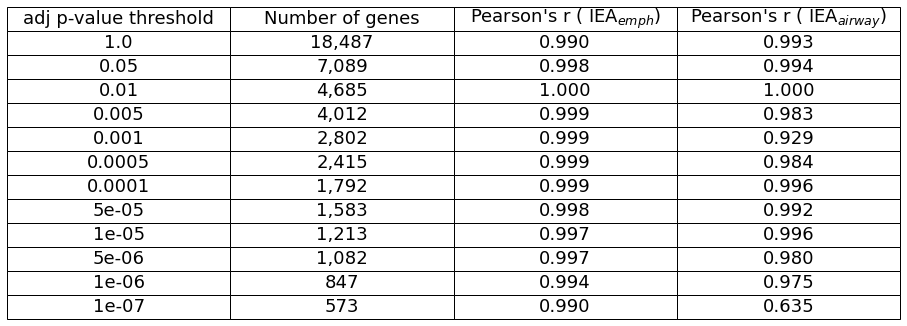

In [17]:
plt.figure(figsize=(8,4))
the_table=plt.table(cellText=tbl, colLabels = cols,
                    colWidths = [.25]*tbl.shape[1], loc='center',cellLoc = "center")
plt.axis('off')
the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)